In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime

  


In [2]:
df = pd.read_csv('/Users/Ptanner/ml_projects/uci_eletric_power_consumption_rnn/data/household_power_consumption.csv',low_memory=False)

In [3]:
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
format_code = "%d/%m/%Y %H:%M:%S"
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format=format_code)


In [5]:
df.isna().sum()

Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
DateTime                     0
dtype: int64

In [6]:
df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean(), inplace=True) # Fill NaNs with mean




/var/folders/0t/5lm7h_6s6qq4j86y_q6lq9880000gp/T/ipykernel_42632/3902033035.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Sub_metering_3'].fillna(df['Sub_metering_3'].mean(), inplace=True) # Fill NaNs with mean


In [7]:
print("Number of records with '?' in Voltage:", len(df[df['Voltage']=='?']))
print("\nExample rows:")
df[df['Voltage']=='?'].head()


Number of records with '?' in Voltage: 25979

Example rows:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,DateTime
6839,21/12/2006,11:23:00,?,?,?,?,?,?,6.458447,2006-12-21 11:23:00
6840,21/12/2006,11:24:00,?,?,?,?,?,?,6.458447,2006-12-21 11:24:00
19724,30/12/2006,10:08:00,?,?,?,?,?,?,6.458447,2006-12-30 10:08:00
19725,30/12/2006,10:09:00,?,?,?,?,?,?,6.458447,2006-12-30 10:09:00
41832,14/1/2007,18:36:00,?,?,?,?,?,?,6.458447,2007-01-14 18:36:00


In [8]:
## Drop all records where any columns have '?'
df.replace('?', np.nan, inplace=True)
df.dropna(inplace=True)

In [9]:
### Convert object columns to numeric

columns_to_convert = ['Global_active_power', 'Global_reactive_power',
  'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
  'Sub_metering_3']
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric)

/var/folders/0t/5lm7h_6s6qq4j86y_q6lq9880000gp/T/ipykernel_42632/2845848522.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df.resample('M', on='DateTime')[col].mean()


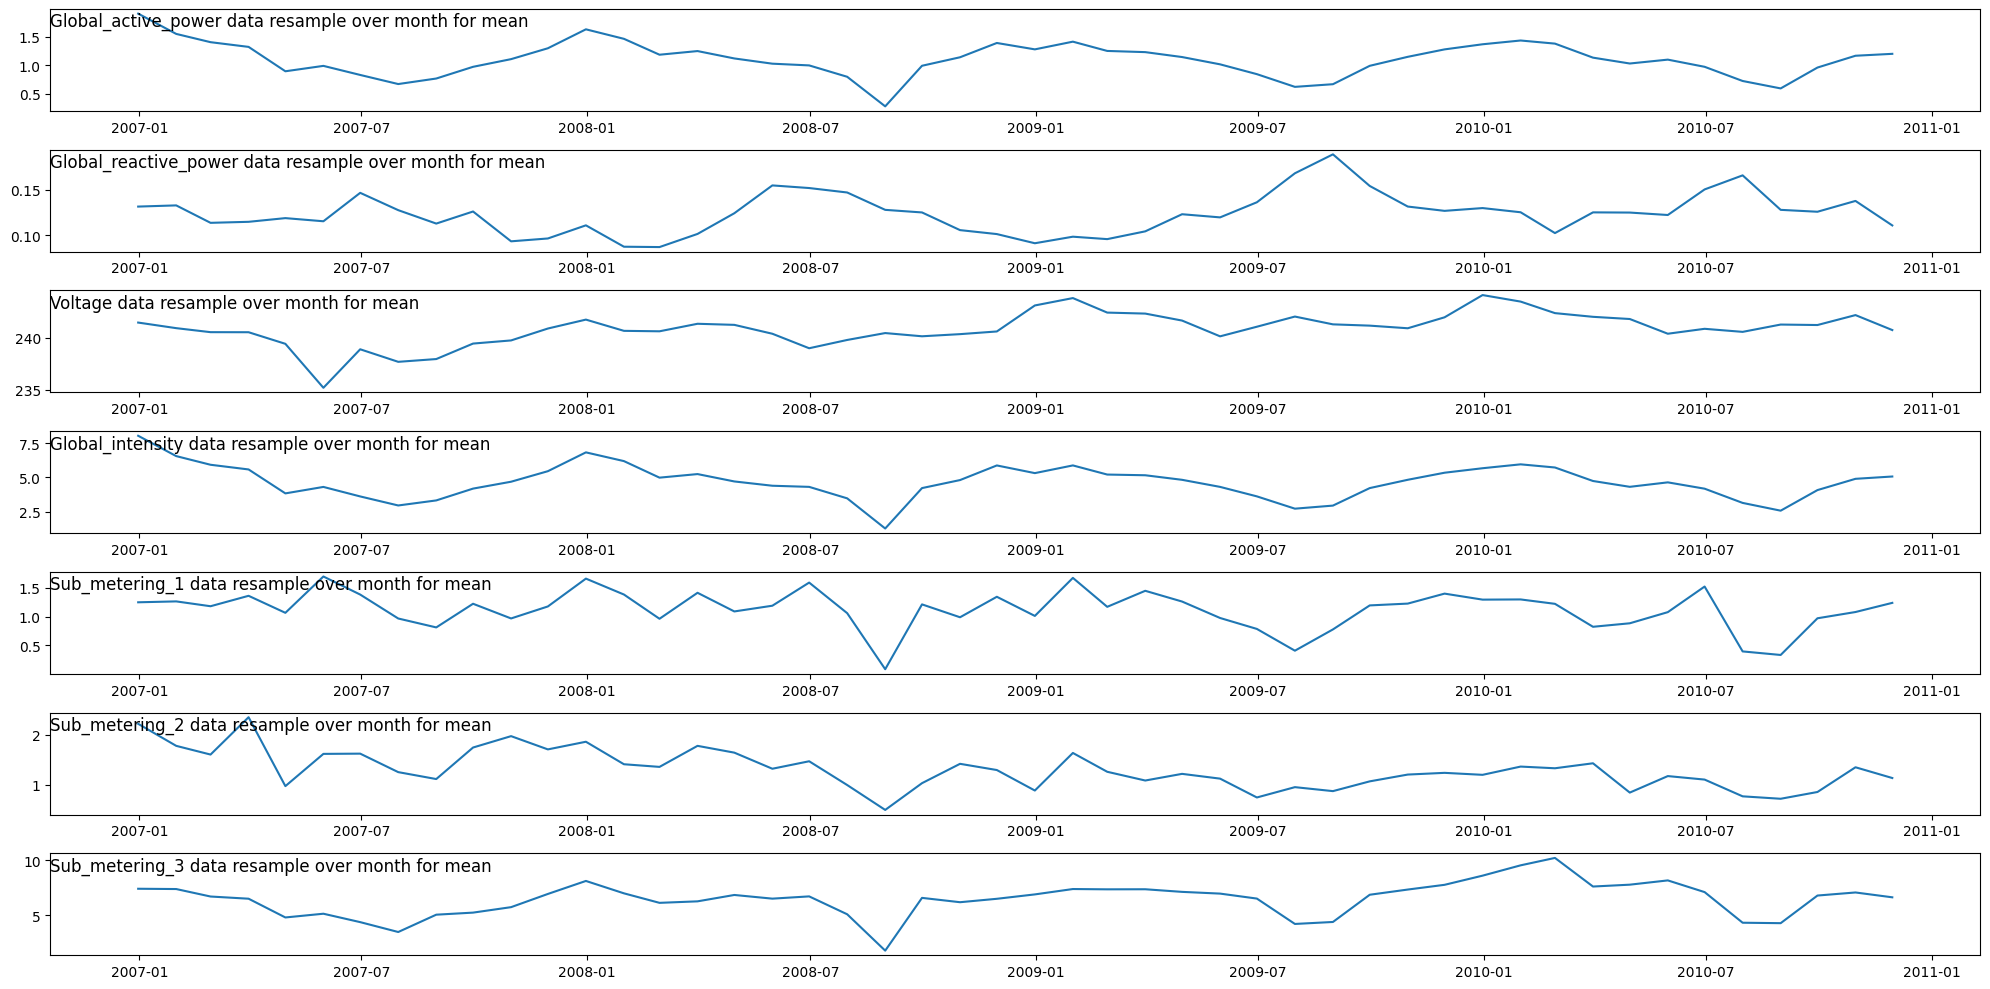

In [10]:
i = 1
cols = ['Global_active_power', 'Global_reactive_power',
  'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
  'Sub_metering_3']
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    monthly_data = df.resample('M', on='DateTime')[col].mean()
    plt.plot(monthly_data.index, monthly_data.values)
    plt.title(col + ' data resample over month for mean', y=0.75, loc='left')
    i += 1
plt.tight_layout()
plt.show()

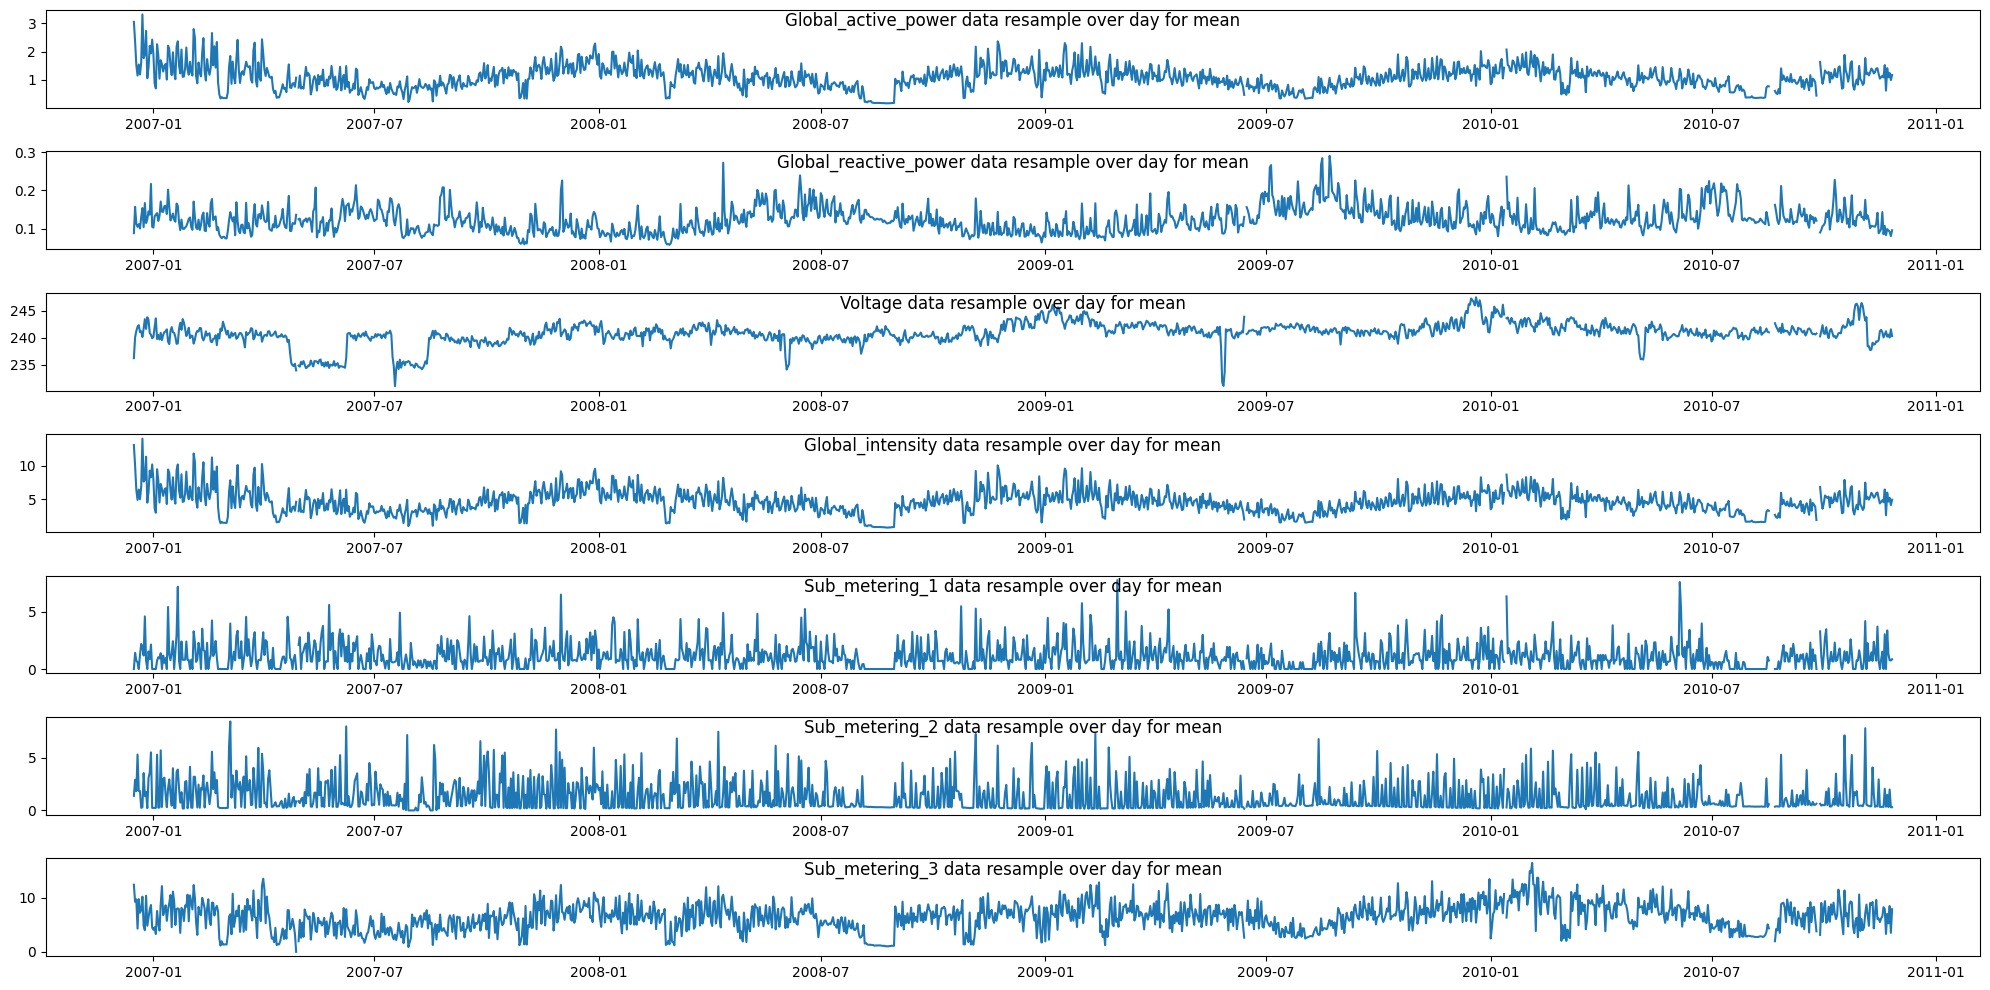

In [11]:
i = 1 
cols = ['Global_active_power', 'Global_reactive_power',
  'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
  'Sub_metering_3']
plt.figure(figsize=(20, 10))
for col in cols:
    plt.subplot(len(cols), 1, i)
    daily_mean = df.resample('D', on='DateTime')[col].mean()
    plt.plot(daily_mean.index, daily_mean.values)
    plt.title(col + ' data resample over day for mean', y=0.75, loc='center')
    i += 1
plt.tight_layout()
plt.show()


In [12]:
print(f'Data set size: {df.shape}')

Data set size: (2049280, 10)


# Correlation HeatMap

Voltage appears to be negatively correlated with our potential target Global Active Power. After doing some research this appears to be related to Voltage dropoff at the moment power surges. Or if we abstract this away it's much like how the water pressure in the house temporarily drops off when you turn on a faucet do to the total release in pressure until the voltage returns to baseline. Could be a great candidate to drop. 


In [13]:
# Get correlation with Global_active_power specifically
correlations = df[columns_to_convert].corr()['Global_active_power'].sort_values(ascending=False)
print("Pearson Correlation with Global_active_power:")
print(correlations)

Pearson Correlation with Global_active_power:
Global_active_power      1.000000
Global_intensity         0.998889
Sub_metering_3           0.638555
Sub_metering_1           0.484401
Sub_metering_2           0.434569
Global_reactive_power    0.247017
Voltage                 -0.399762
Name: Global_active_power, dtype: float64


In [15]:
columns_to_convert.append('DateTime')

/var/folders/0t/5lm7h_6s6qq4j86y_q6lq9880000gp/T/ipykernel_42632/138547727.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dfm = df[columns_to_convert].set_index('DateTime').resample('M').mean()
/var/folders/0t/5lm7h_6s6qq4j86y_q6lq9880000gp/T/ipykernel_42632/138547727.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dfh = df[columns_to_convert].set_index('DateTime').resample('H').mean()


Text(0.5, 1.0, 'Hourly resampling')

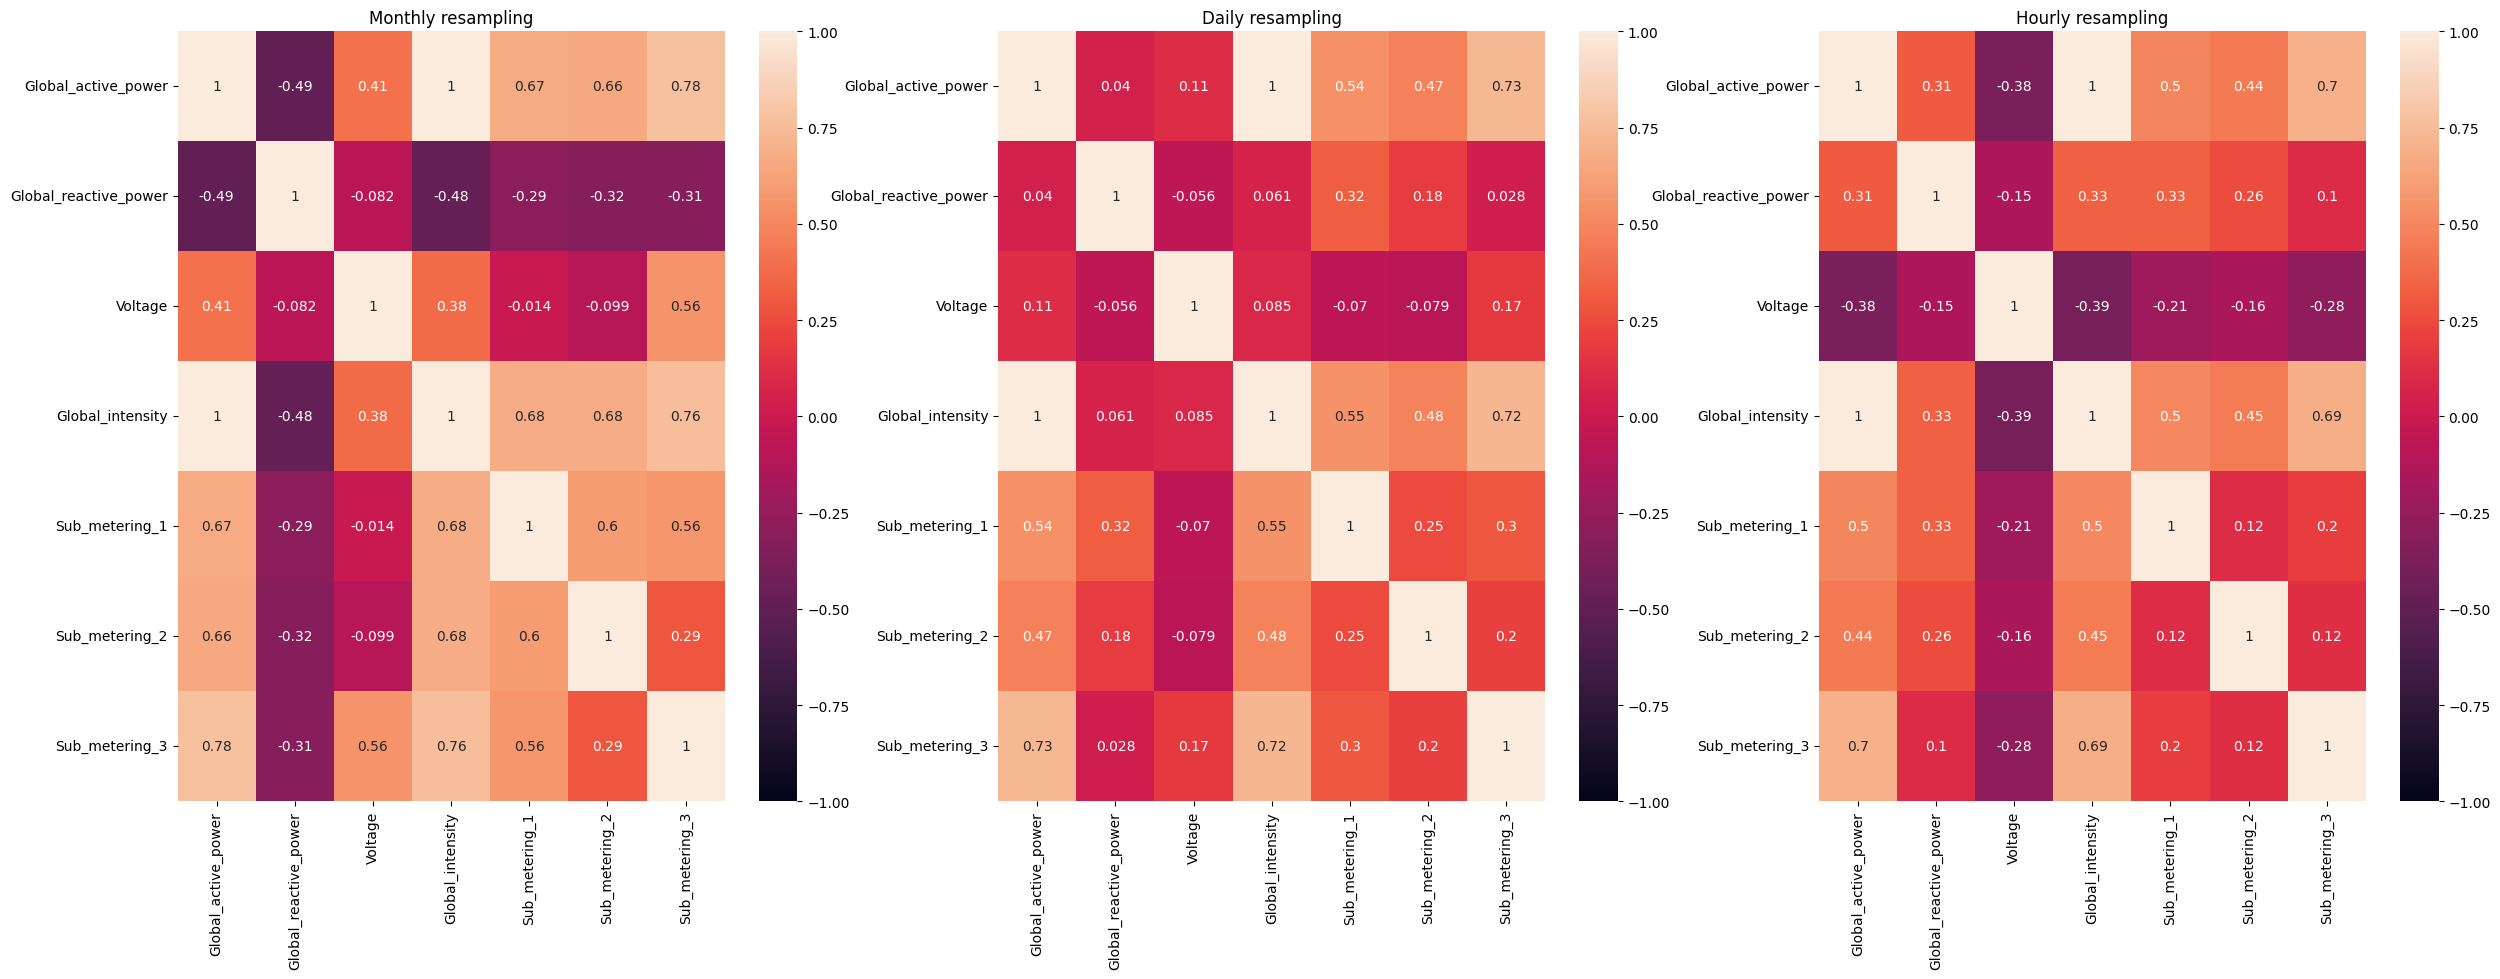

In [17]:
f = plt.figure(figsize=(30,10))

ax = f.add_subplot(131)
dfm = df[columns_to_convert].set_index('DateTime').resample('M').mean()
sns.heatmap(dfm.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Monthly resampling', size=12)

ax = f.add_subplot(132)
dfd = df[columns_to_convert].set_index('DateTime').resample('D').mean()
sns.heatmap(dfd.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Daily resampling', size=12)  

ax = f.add_subplot(133)
dfh = df[columns_to_convert].set_index('DateTime').resample('H').mean()
sns.heatmap(dfh.corr(), vmin=-1, vmax=1, annot=True)
plt.title('Hourly resampling', size=12)

In [18]:
def df_to_X_y(df, window_size = 5):
  df_as_np = df.to_numpy()
  X = list()
  y = list()
  for i in range(len(df_as_np) - window_size):
    row = [[a] for a in df_as_np[i:i+5]]
    X.append(row)
    label = df_as_np[i+5]
    y.append(label)
  return np.array(X), np.array(y)

In [24]:
df.index = pd.to_datetime(df['DateTime'],format = format_code)

In [25]:
df_array = df['Global_active_power']

In [29]:
df_array.shape

(2049280,)

In [36]:
###plot global active power by week 
hourly_mean = df_array.resample('H').mean()
daily_mean = df_array.resample('D').mean()
weekly_mean = df_array.resample('W').mean()
monthly_mean = df_array.resample('M').mean()


/var/folders/0t/5lm7h_6s6qq4j86y_q6lq9880000gp/T/ipykernel_42632/2966573409.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly_mean = df_array.resample('H').mean()
/var/folders/0t/5lm7h_6s6qq4j86y_q6lq9880000gp/T/ipykernel_42632/2966573409.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_mean = df_array.resample('M').mean()


In [40]:
print(f'Hourly Mean record count: {len(hourly_mean)}')
print(f'columns: {hourly_mean.columns}')
print(f'Daily Mean record count: {len(daily_mean)}')
print(f'Weekly Mean record count: {len(weekly_mean)}')
[print(f'monthly_mean record count: {len(monthly_mean)}')]

Hourly Mean record count: 34589


AttributeError: 'Series' object has no attribute 'columns'

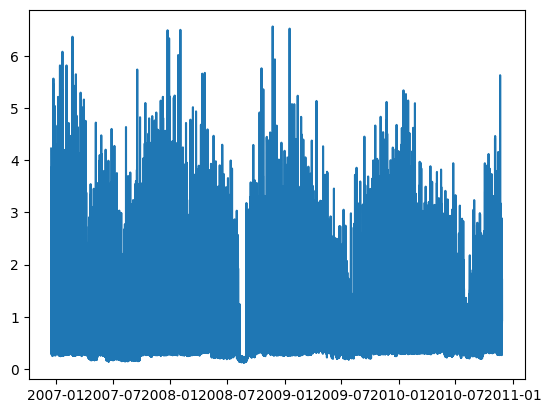

In [42]:
plt.plot(hourly_mean)